In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
os.chdir('/content/drive/MyDrive/NLP/Starbucks Reviews Analysis')
!ls

 reviews_data.csv  'Starbucks Reviews Analysis.ipynb'


In [68]:
!pip install emoji

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import emoji
import spacy

nlp = spacy.load('en_core_web_sm')

import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalMaxPooling1D,Embedding,Dense,LSTM

from sklearn.metrics import accuracy_score

In [38]:
data = pd.read_csv('reviews_data.csv')
data.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [40]:
data.isnull().sum()

,0
name,0
location,0
Date,0
Rating,145
Review,0
Image_Links,0


<Axes: >

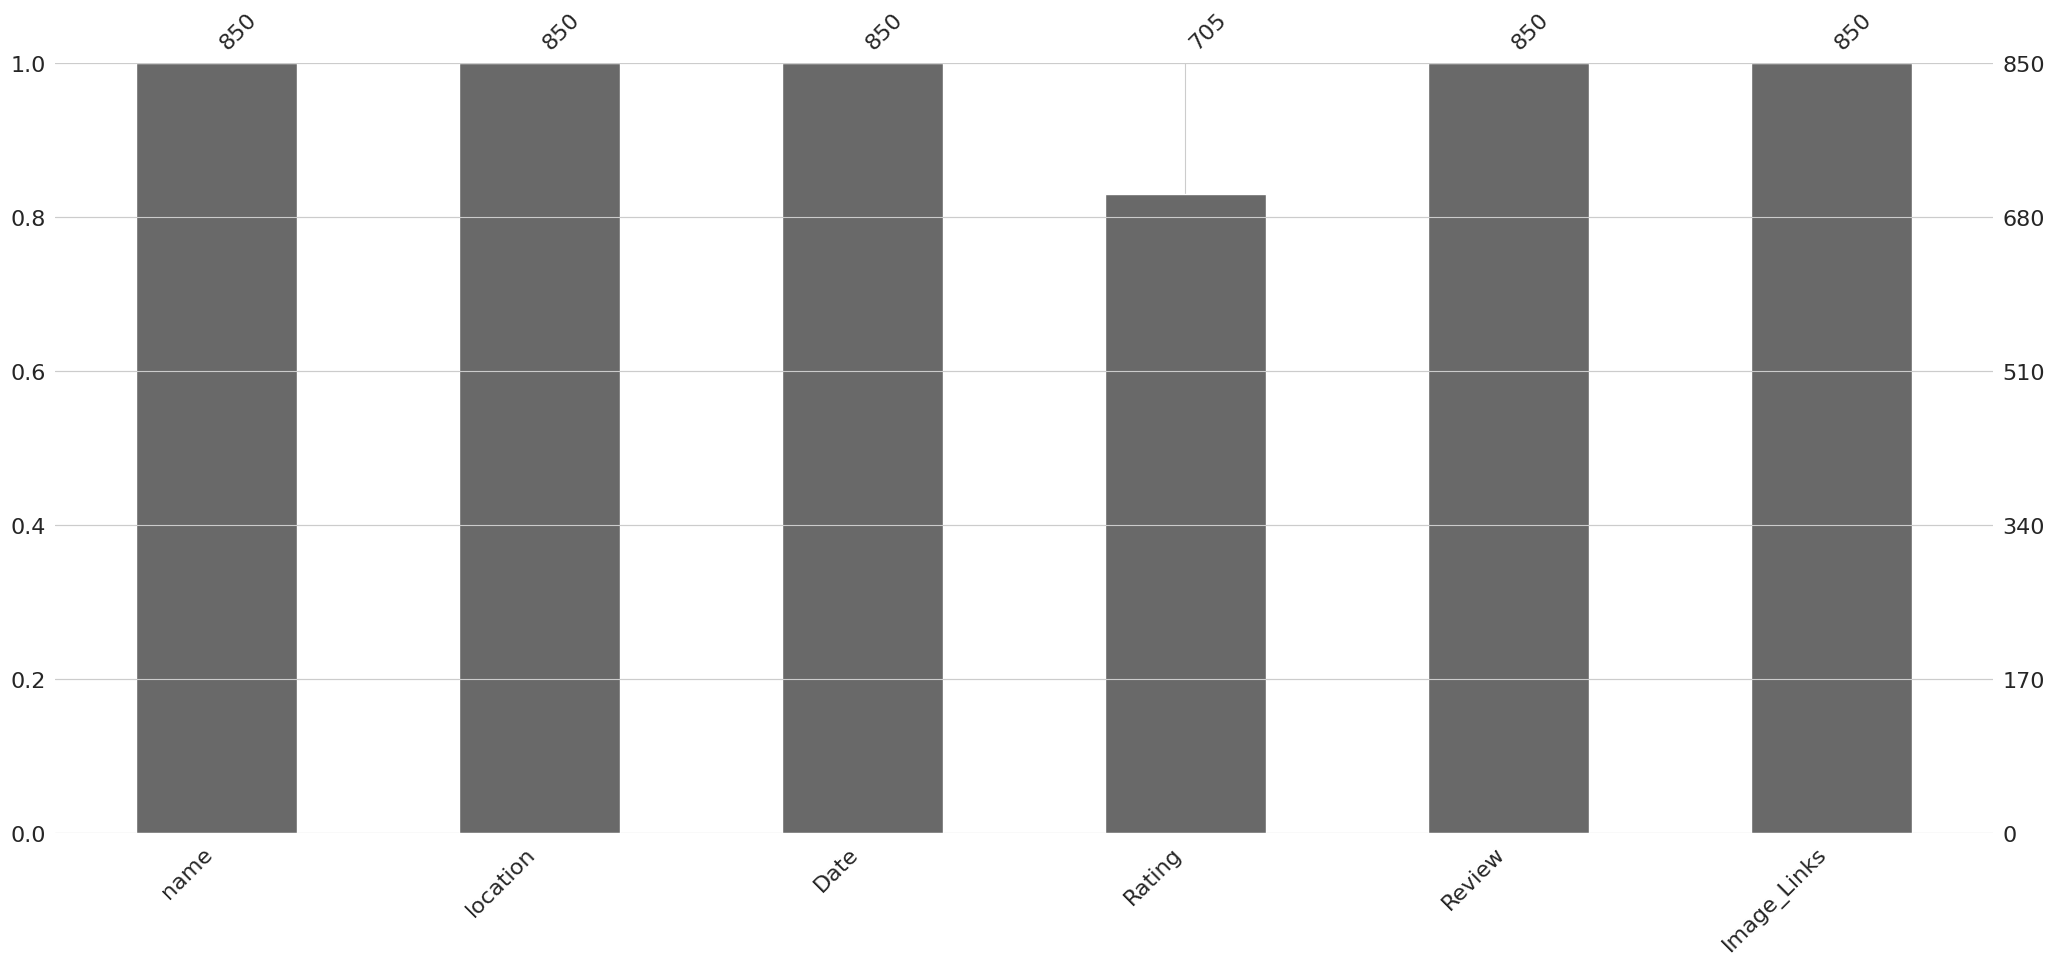

In [41]:
msno.bar(data)

In [42]:
data.dropna(inplace=True)
data.drop(columns=['Image_Links'],inplace=True)

<Axes: xlabel='Rating', ylabel='count'>

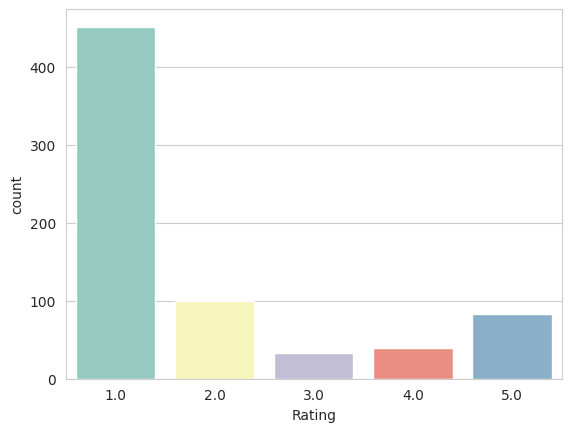

In [43]:
sns.countplot(x='Rating',data=data,palette='Set3')

In [44]:
data['Rating'] = data['Rating'].replace([1,2],2)
data['Rating'] = data['Rating'].replace(3,0)
data['Rating'] = data['Rating'].replace([4,5],1)
data = data.dropna(axis=0,how='any')
data['Rating'] = data['Rating'].astype(int)

In [45]:
data['Rating'].value_counts()

,count
Rating,
2,550
1,122
0,33


([<matplotlib.patches.Wedge at 0x795f59d2cd90>,
 [Text(-0.7007886668374206, -0.8478769040563795, 'Negative'),
  Text(0.8174593746413996, 0.7360435930098788, 'Positive'),
  Text(0.16117633774184556, 1.0881278363097449, 'Neural')],
 [Text(-0.3822483637295021, -0.46247831130347966, '78.0%'),
  Text(0.4458869316225816, 0.40147832345993384, '17.3%'),
  Text(0.08791436604100665, 0.5935242743507698, '4.7%')])

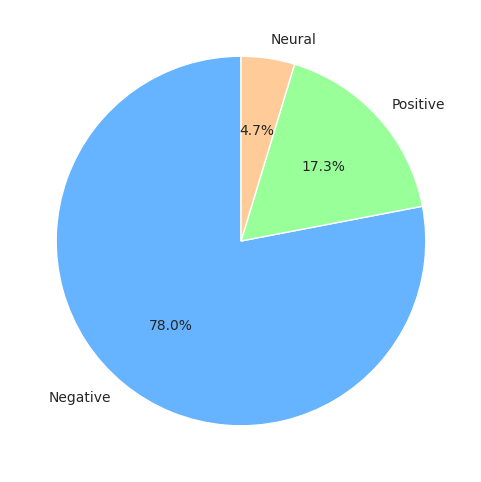

In [46]:
plt.figure(figsize=(6,6))
sns.set_style('whitegrid')
plt.pie(data['Rating'].value_counts(),labels=['Negative','Positive','Neural'],autopct='%1.1f%%',colors=['#66b3ff','#99ff99','#ffcc99'],startangle=90)

In [47]:
data['location'] = data['location'].str.split(',').str[1]

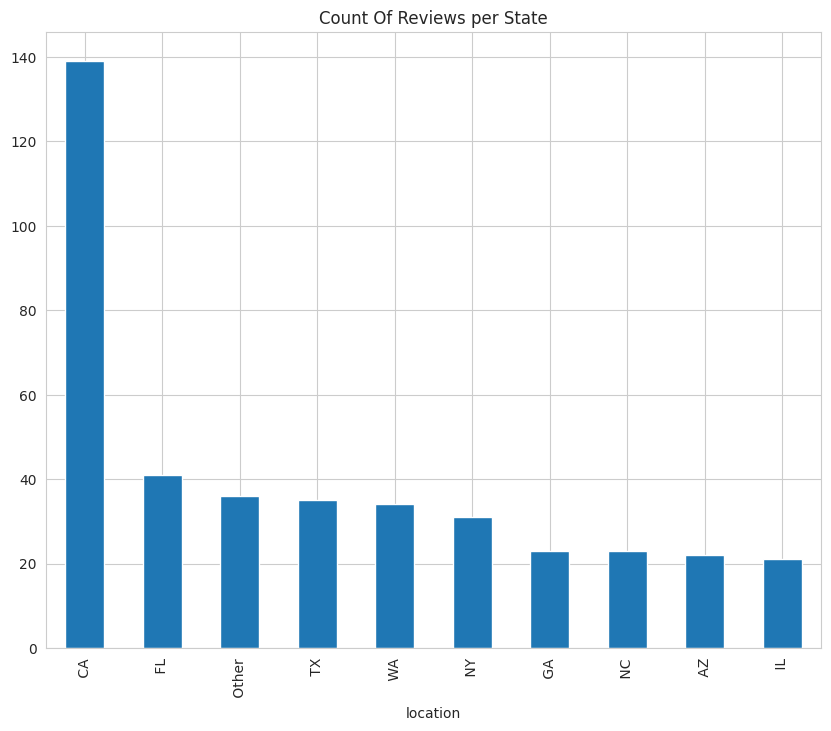

In [48]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
data["location"].value_counts().sort_values(ascending= False).head(10).plot.bar()
plt.title("Count Of Reviews per State");

In [49]:
df = data[['location','Rating']]
df['Negative'] = df[df['Rating'] == 2]['Rating']
df['Positive'] = df[df['Rating'] == 1]['Rating']
df['Neutral'] = df[df['Rating'] == 0]['Rating']
df.drop('Rating',axis=1,inplace=True)
df = df.groupby('location').count().sort_values(ascending=False,by='Negative').head(9)

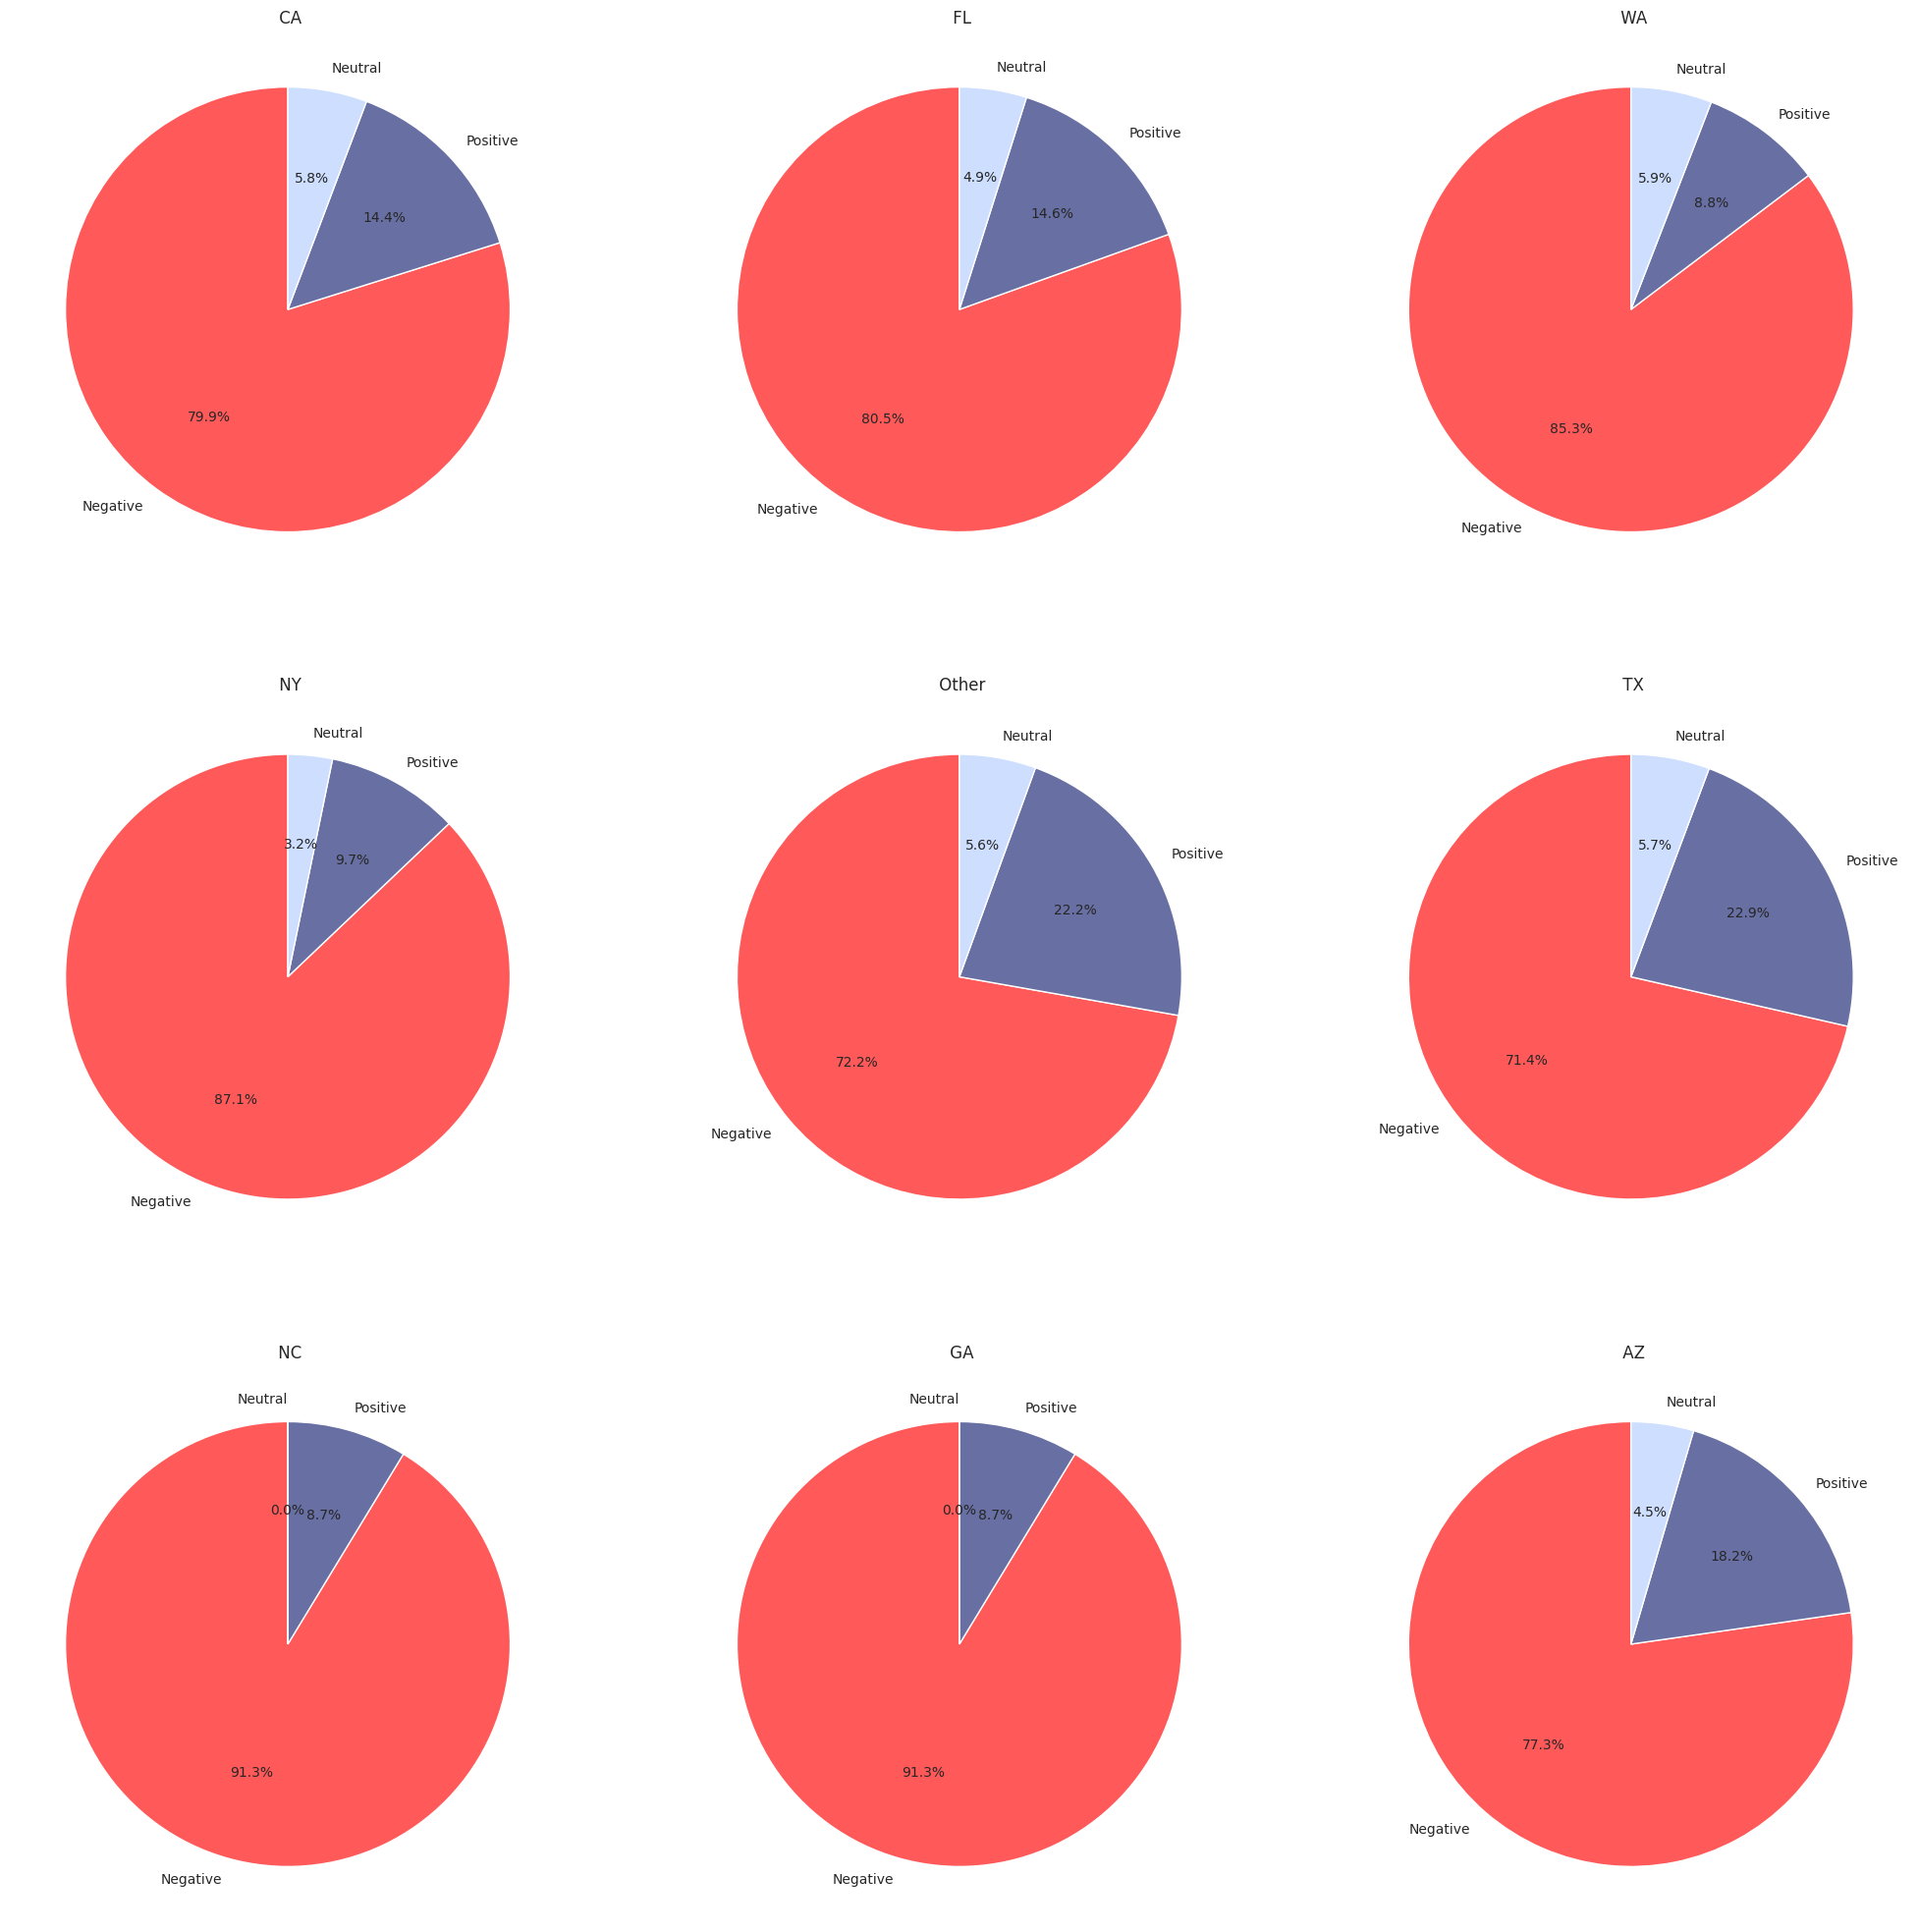

In [50]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3, 3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

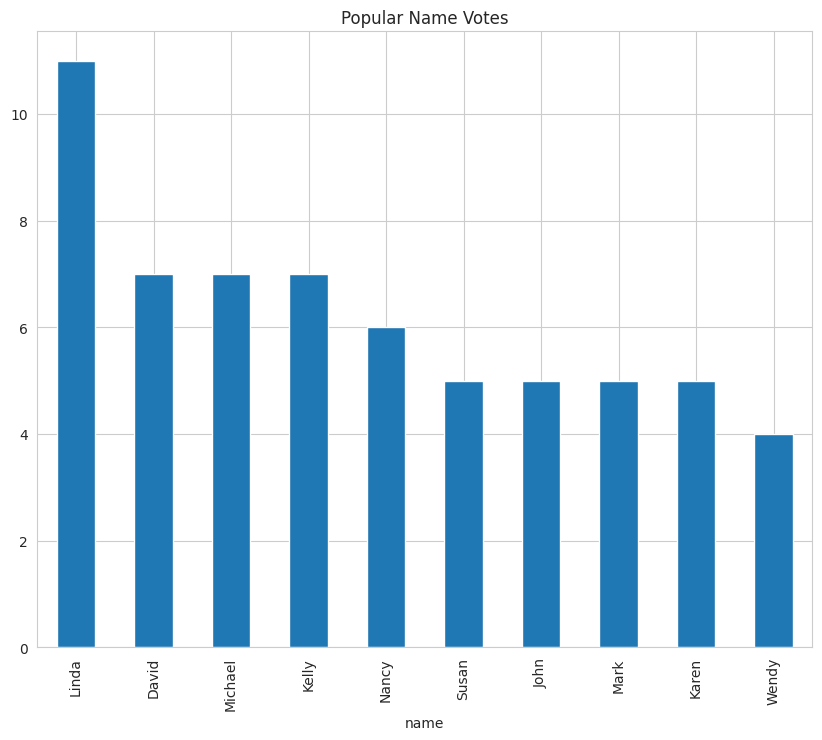

In [51]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
data["name"].value_counts().sort_values(ascending= False).head(10).plot.bar()
plt.title("Popular Name Votes");

In [52]:
df = data[['name','Rating']]
df['Negative'] = df[df['Rating'] == 2]['Rating']
df['Positive'] = df[df['Rating']==1]['Rating']
df['Neutral'] = df[df['Rating'] == 0]['Rating']
df.drop('Rating',axis=1,inplace=True)
df = df.groupby('name').count().sort_values(ascending=False,by='Negative').head(9)

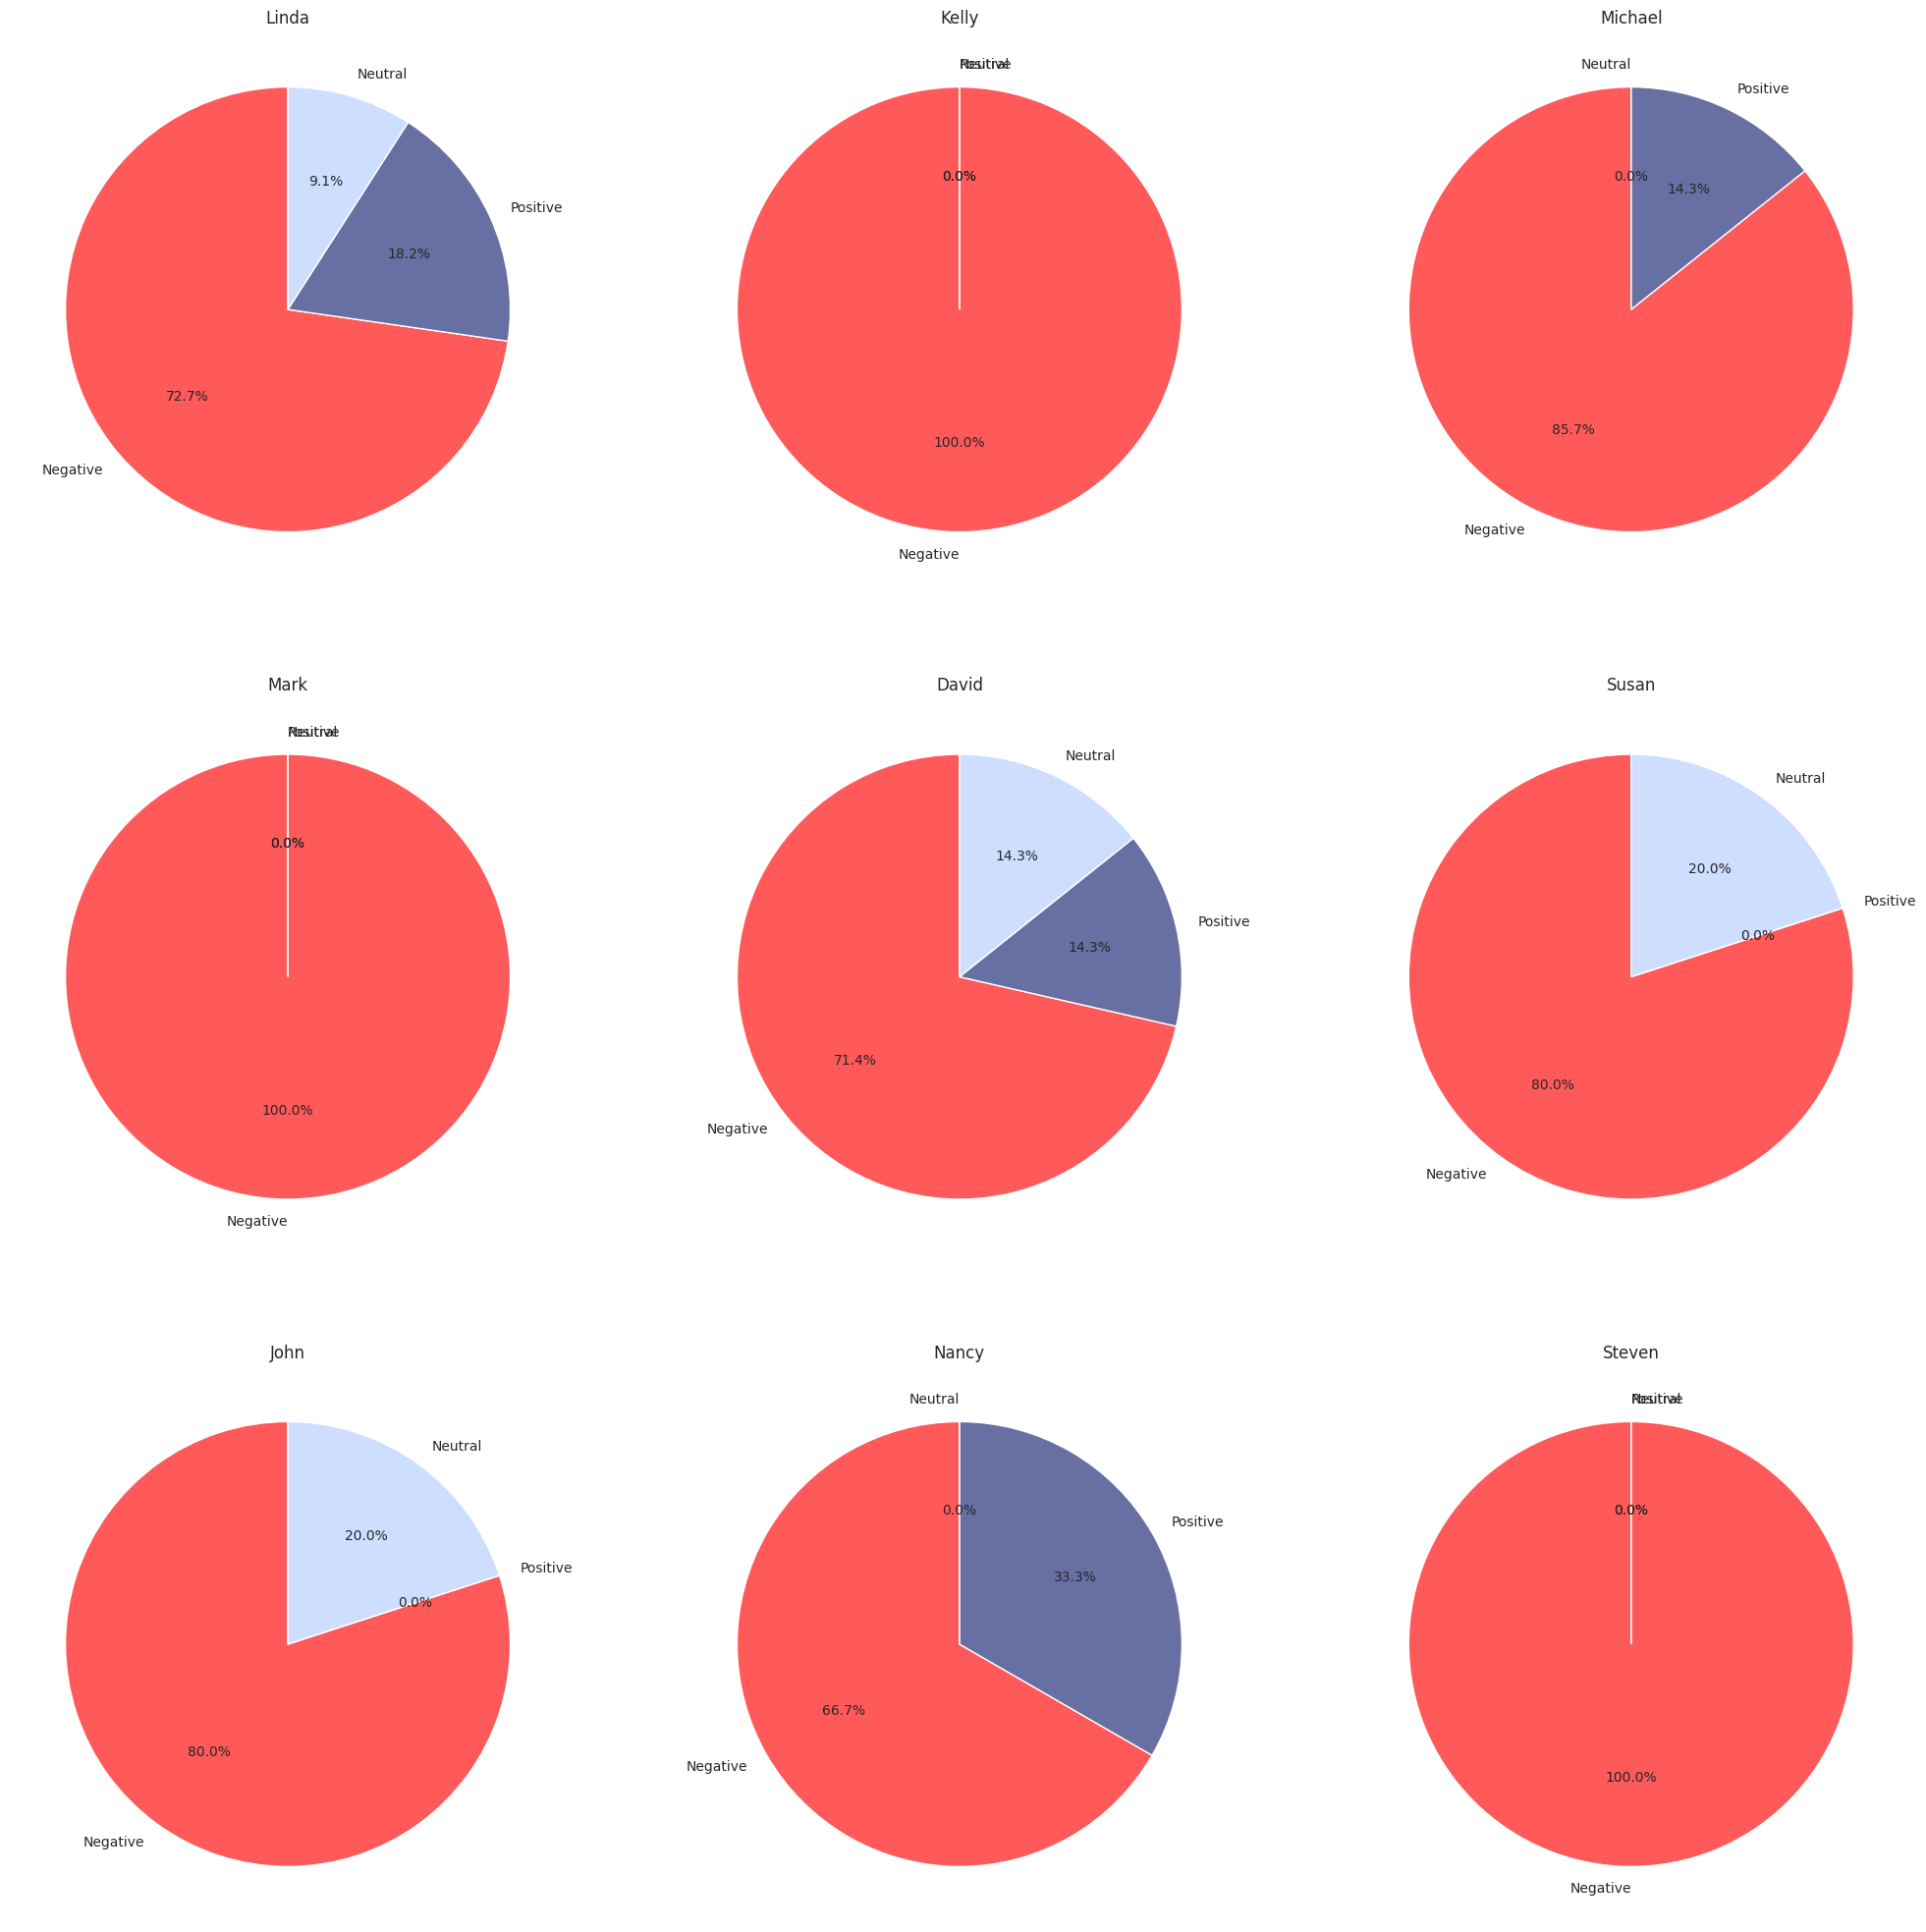

In [53]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3, 3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

In [54]:
data['Date'] = data['Date'].str.replace("Reviewed", "", case=False, regex=False)
data = data.astype({'Date': 'datetime64[ns]'})
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.dayofweek

([<matplotlib.axis.XTick at 0x795f57dbb1d0>,
 [Text(0, 0, 'Sunday'),
  Text(1, 0, 'Monday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Wednesday'),
  Text(4, 0, 'Thursday'),
  Text(5, 0, 'Friday'),
  Text(6, 0, 'Saturday')])

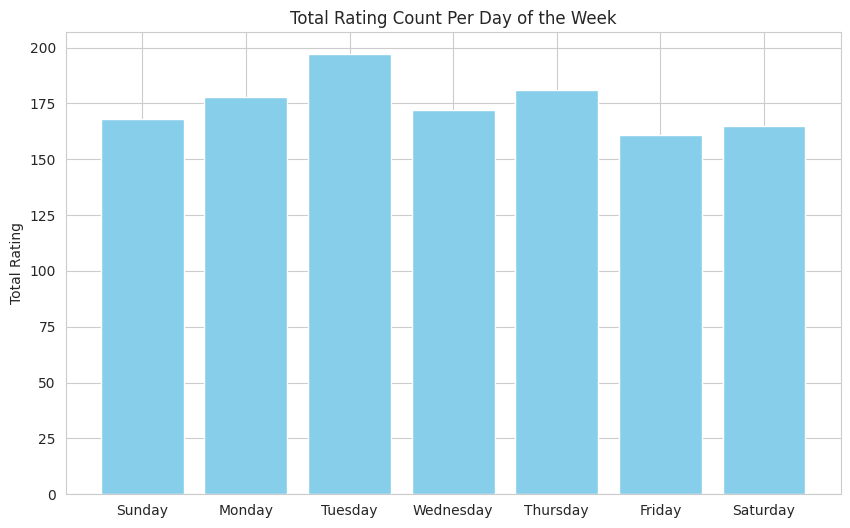

In [55]:
day_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df = data.groupby(['DayOfWeek'])['Rating'].sum().reset_index()


plt.figure(figsize=(10,6))
plt.bar(df['DayOfWeek'],df['Rating'],color='skyblue')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Day of the Week')
plt.xticks(df['DayOfWeek'],labels=day_order)

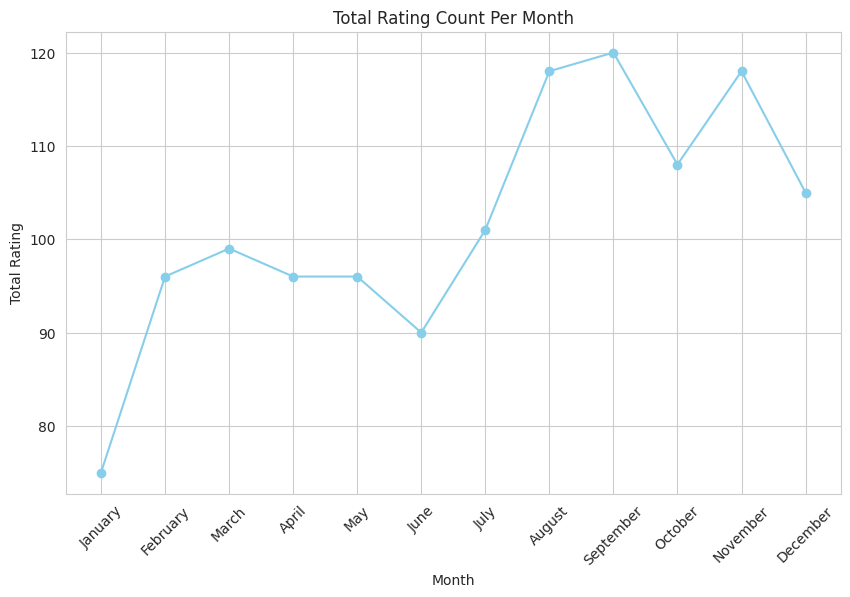

In [56]:
df = data.groupby(['Month'])['Rating'].sum().reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Rating'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Month')

plt.xticks(df['Month'], labels=month_order,rotation=45)
plt.grid(True)
plt.show()

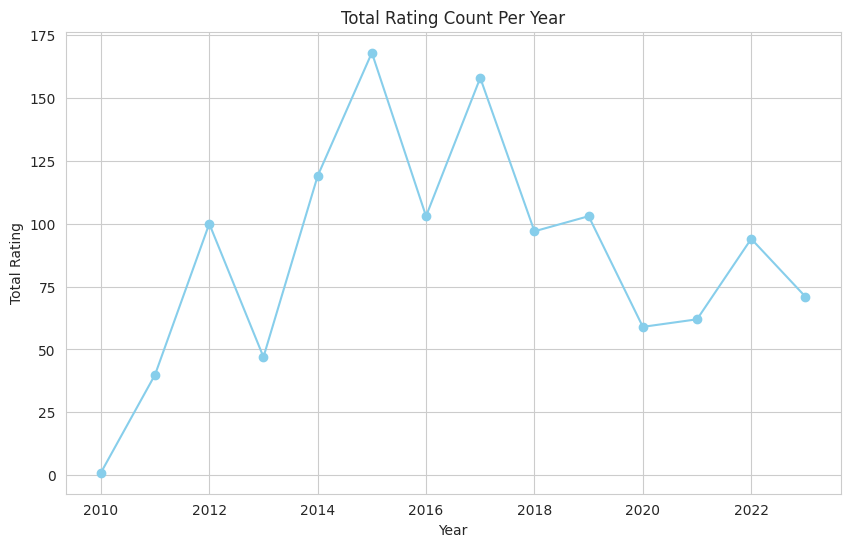

In [57]:
df = data.groupby(['Year'])['Rating'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Rating'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Year')
plt.grid(True)
plt.show()

In [58]:
df = data[['DayOfWeek','Rating']]

df['Negative'] = df[df['Rating']==2]['Rating']
df['Positive'] = df[df['Rating']==1]['Rating']
df['Neutral'] = df[df['Rating']==0]['Rating']
df.drop('Rating',axis=1,inplace=True)
df = df.groupby('DayOfWeek').count()

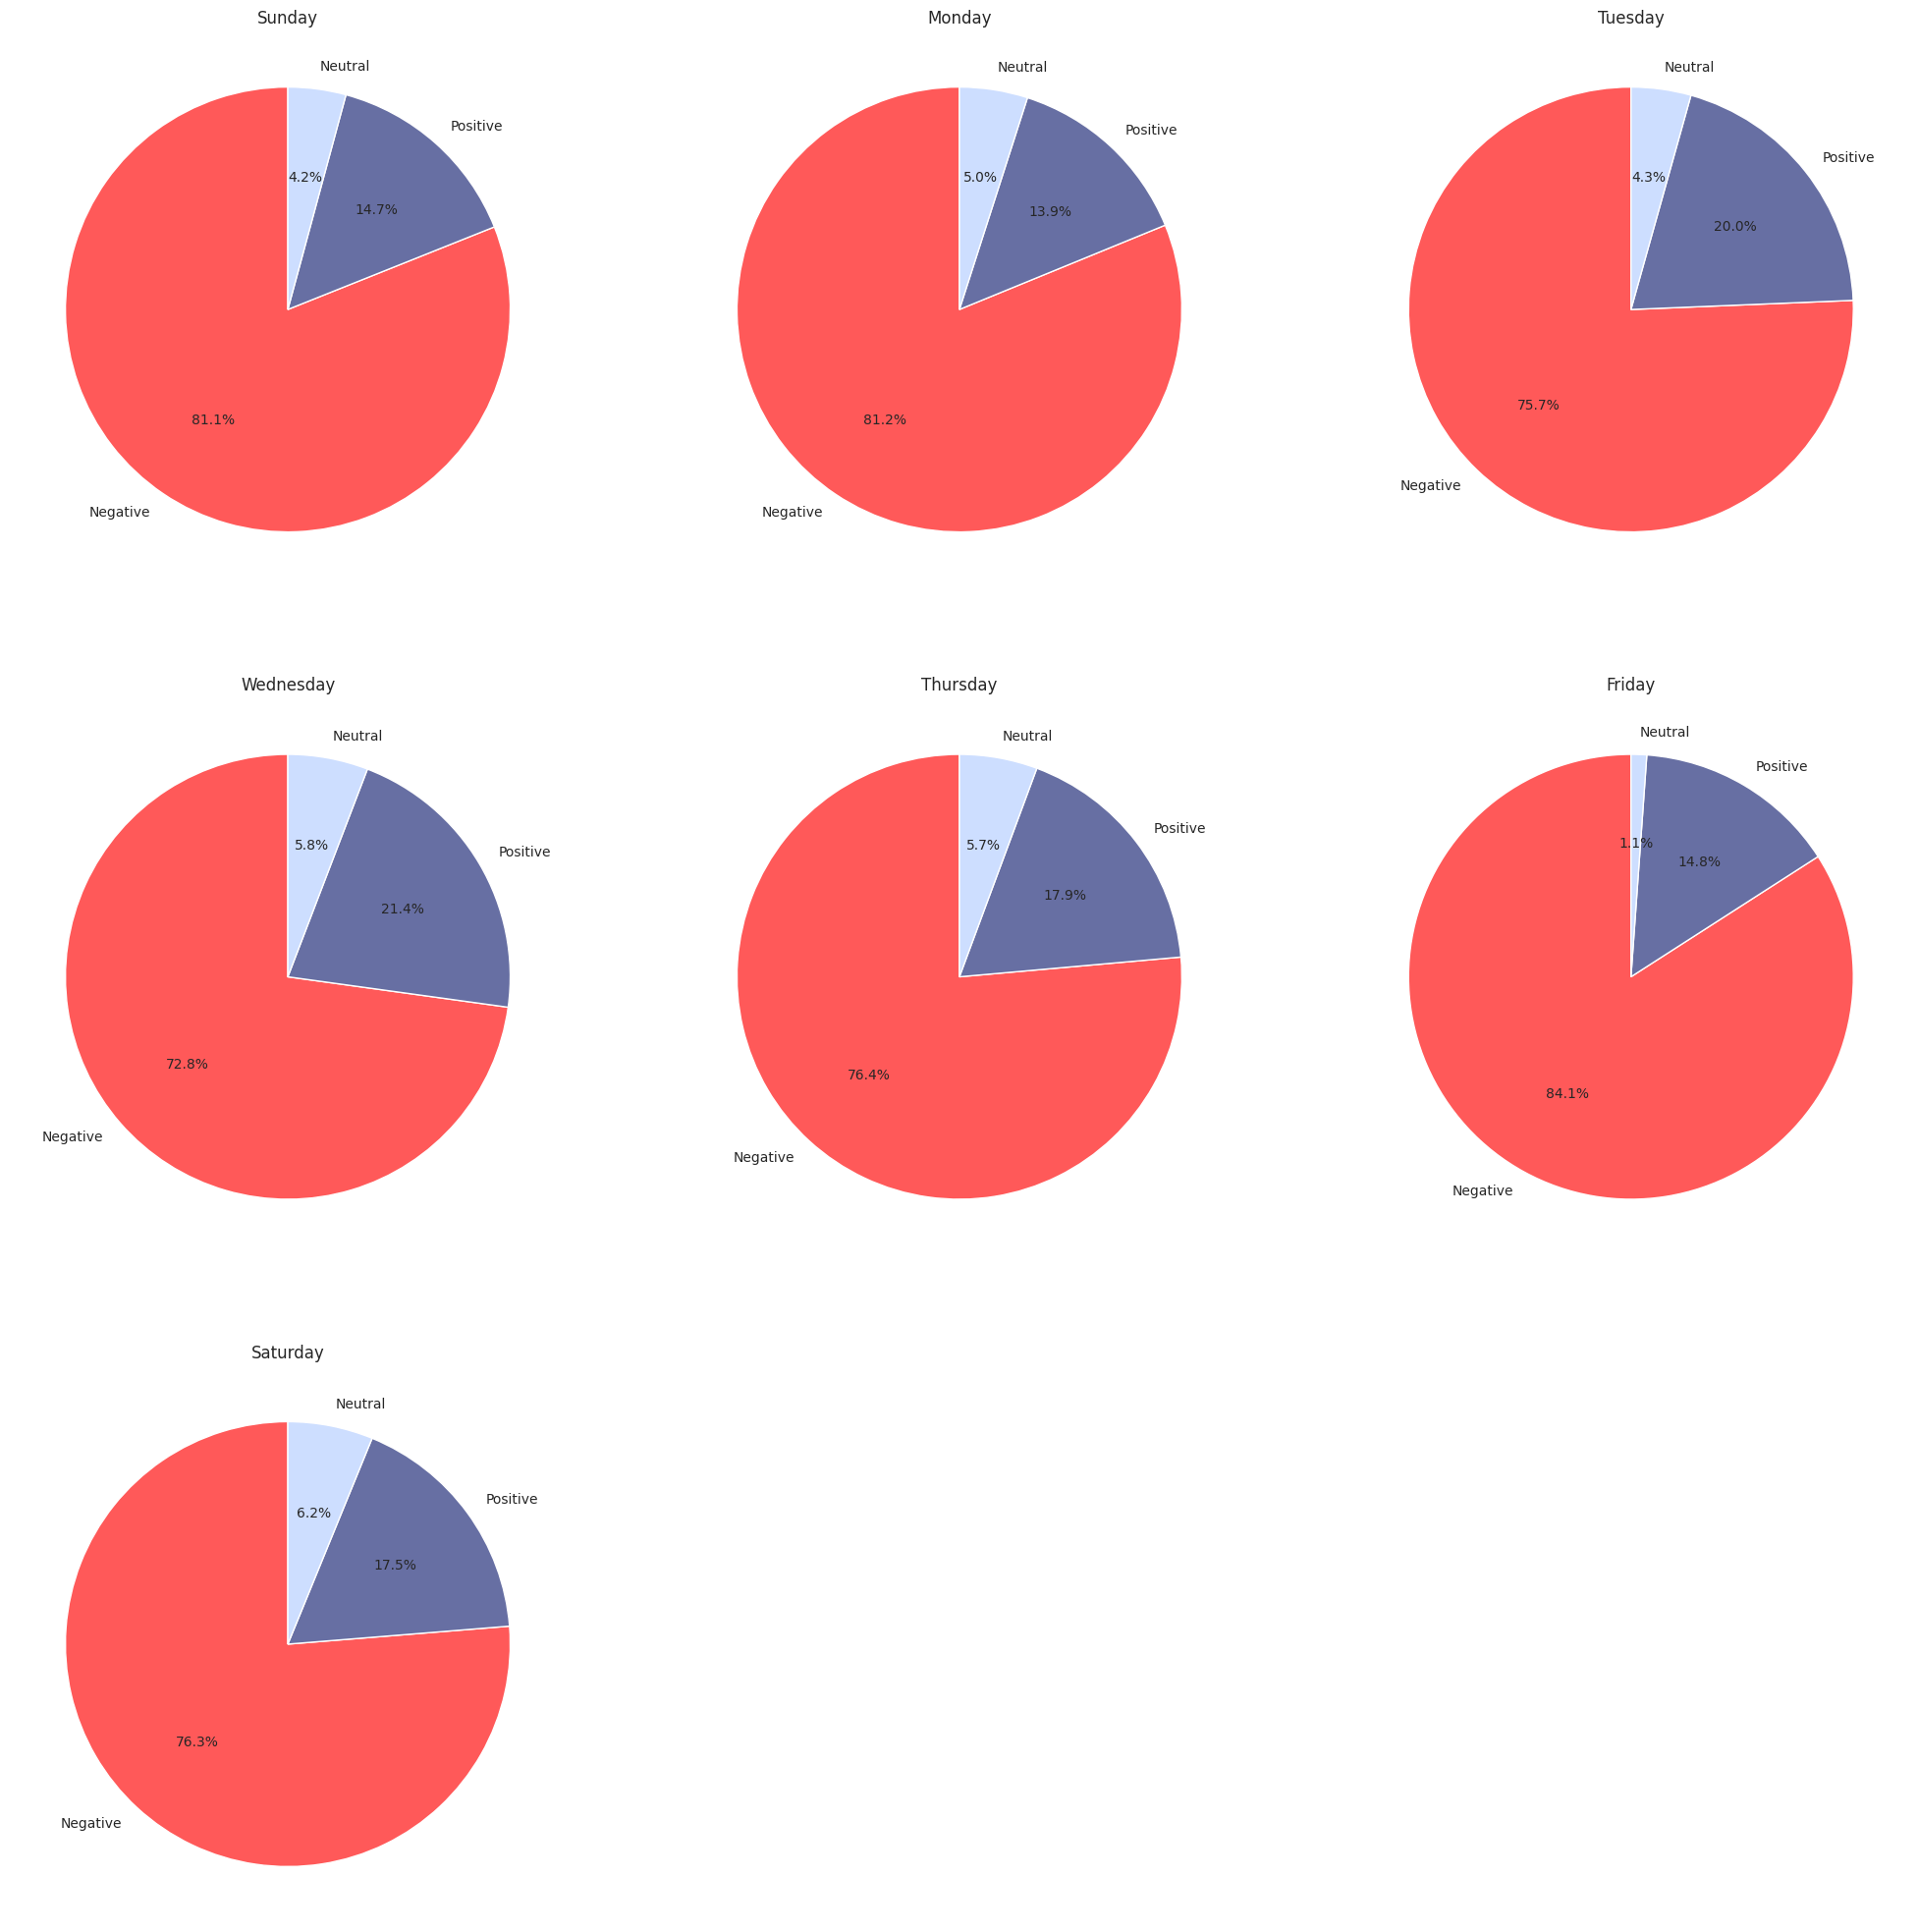

In [59]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3,3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(day_order[x], loc='center')
    i+=1
plt.show()

In [60]:
df = data[['Month','Rating']]
df['Negative'] = df[df['Rating']==2]['Rating']
df['Positive'] = df[df['Rating']==1]['Rating']
df['Neutral'] = df[df['Rating']==0]['Rating']
df.drop('Rating',axis=1,inplace=True)
df = df.groupby('Month').count()

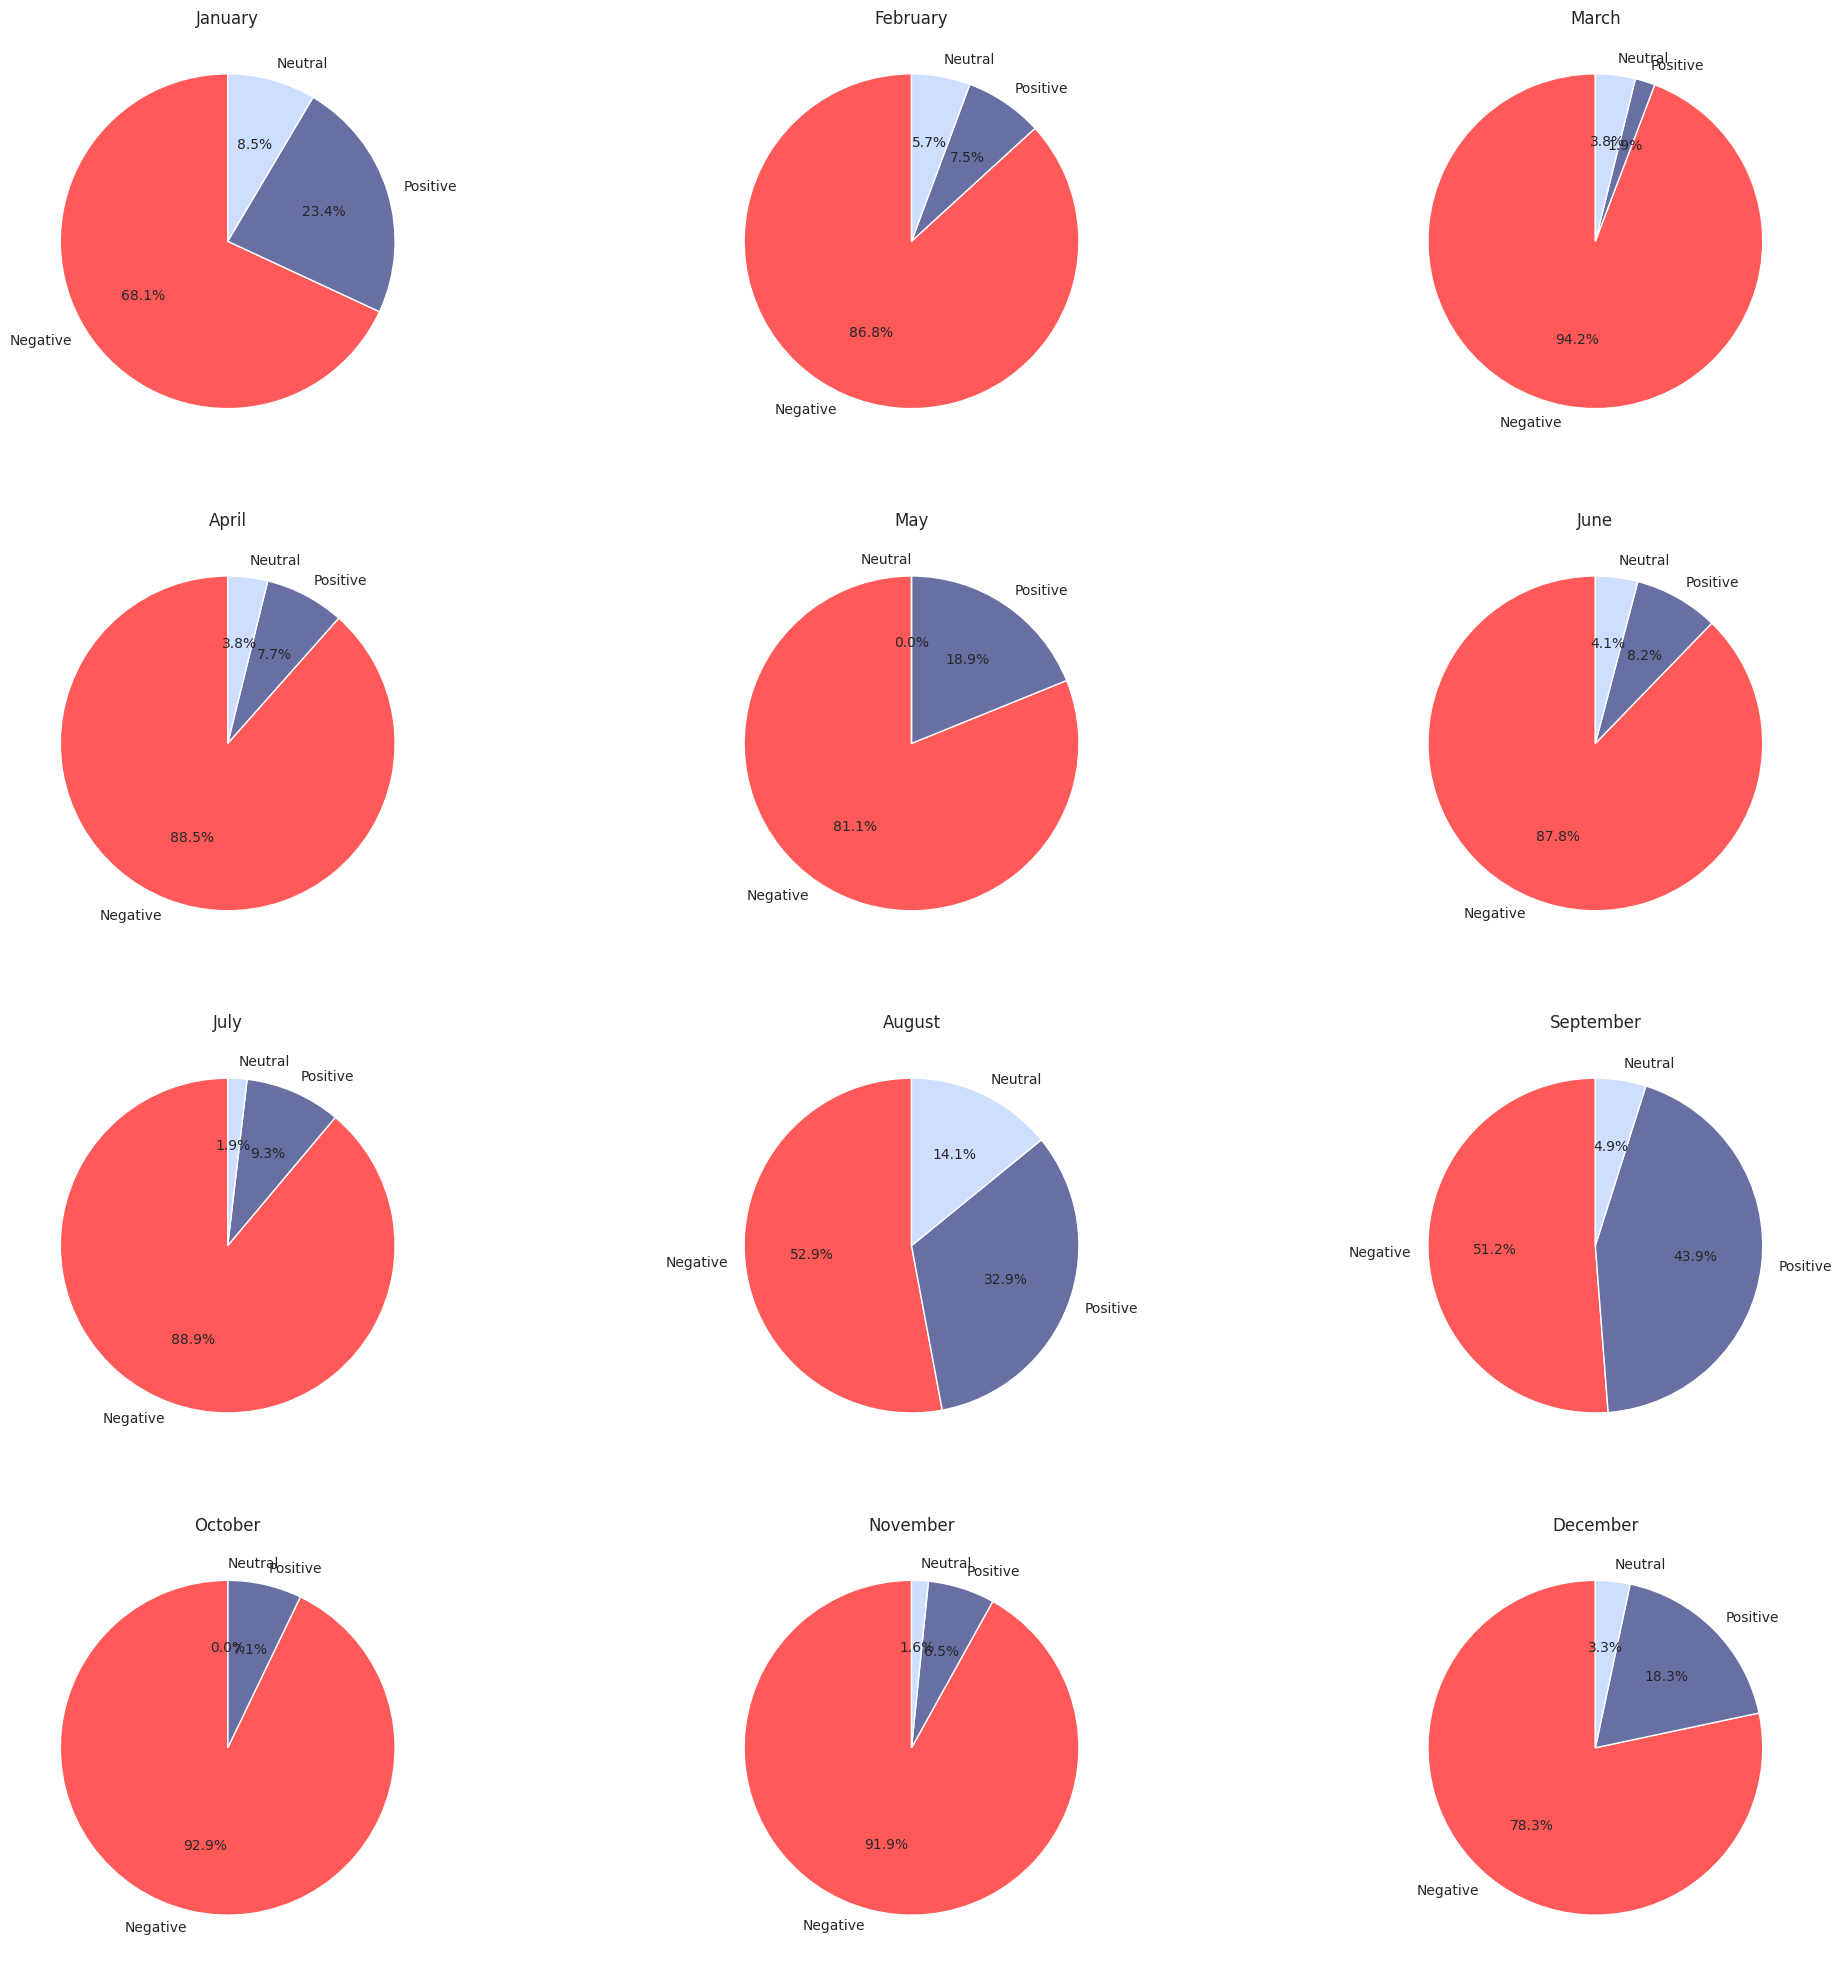

In [61]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4,3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(month_order[x-1], loc='center')
    i+=1
plt.show()

In [62]:
df = data[['Year','Rating']]
df['Negative'] = df[df["Rating"]==2]["Rating"]
df['Positive'] = df[df["Rating"]==1]["Rating"]
df['Neutral'] = df[df["Rating"]==0]["Rating"]
df.drop('Rating',axis=1,inplace=True)
df = df.groupby('Year').count()[1:]

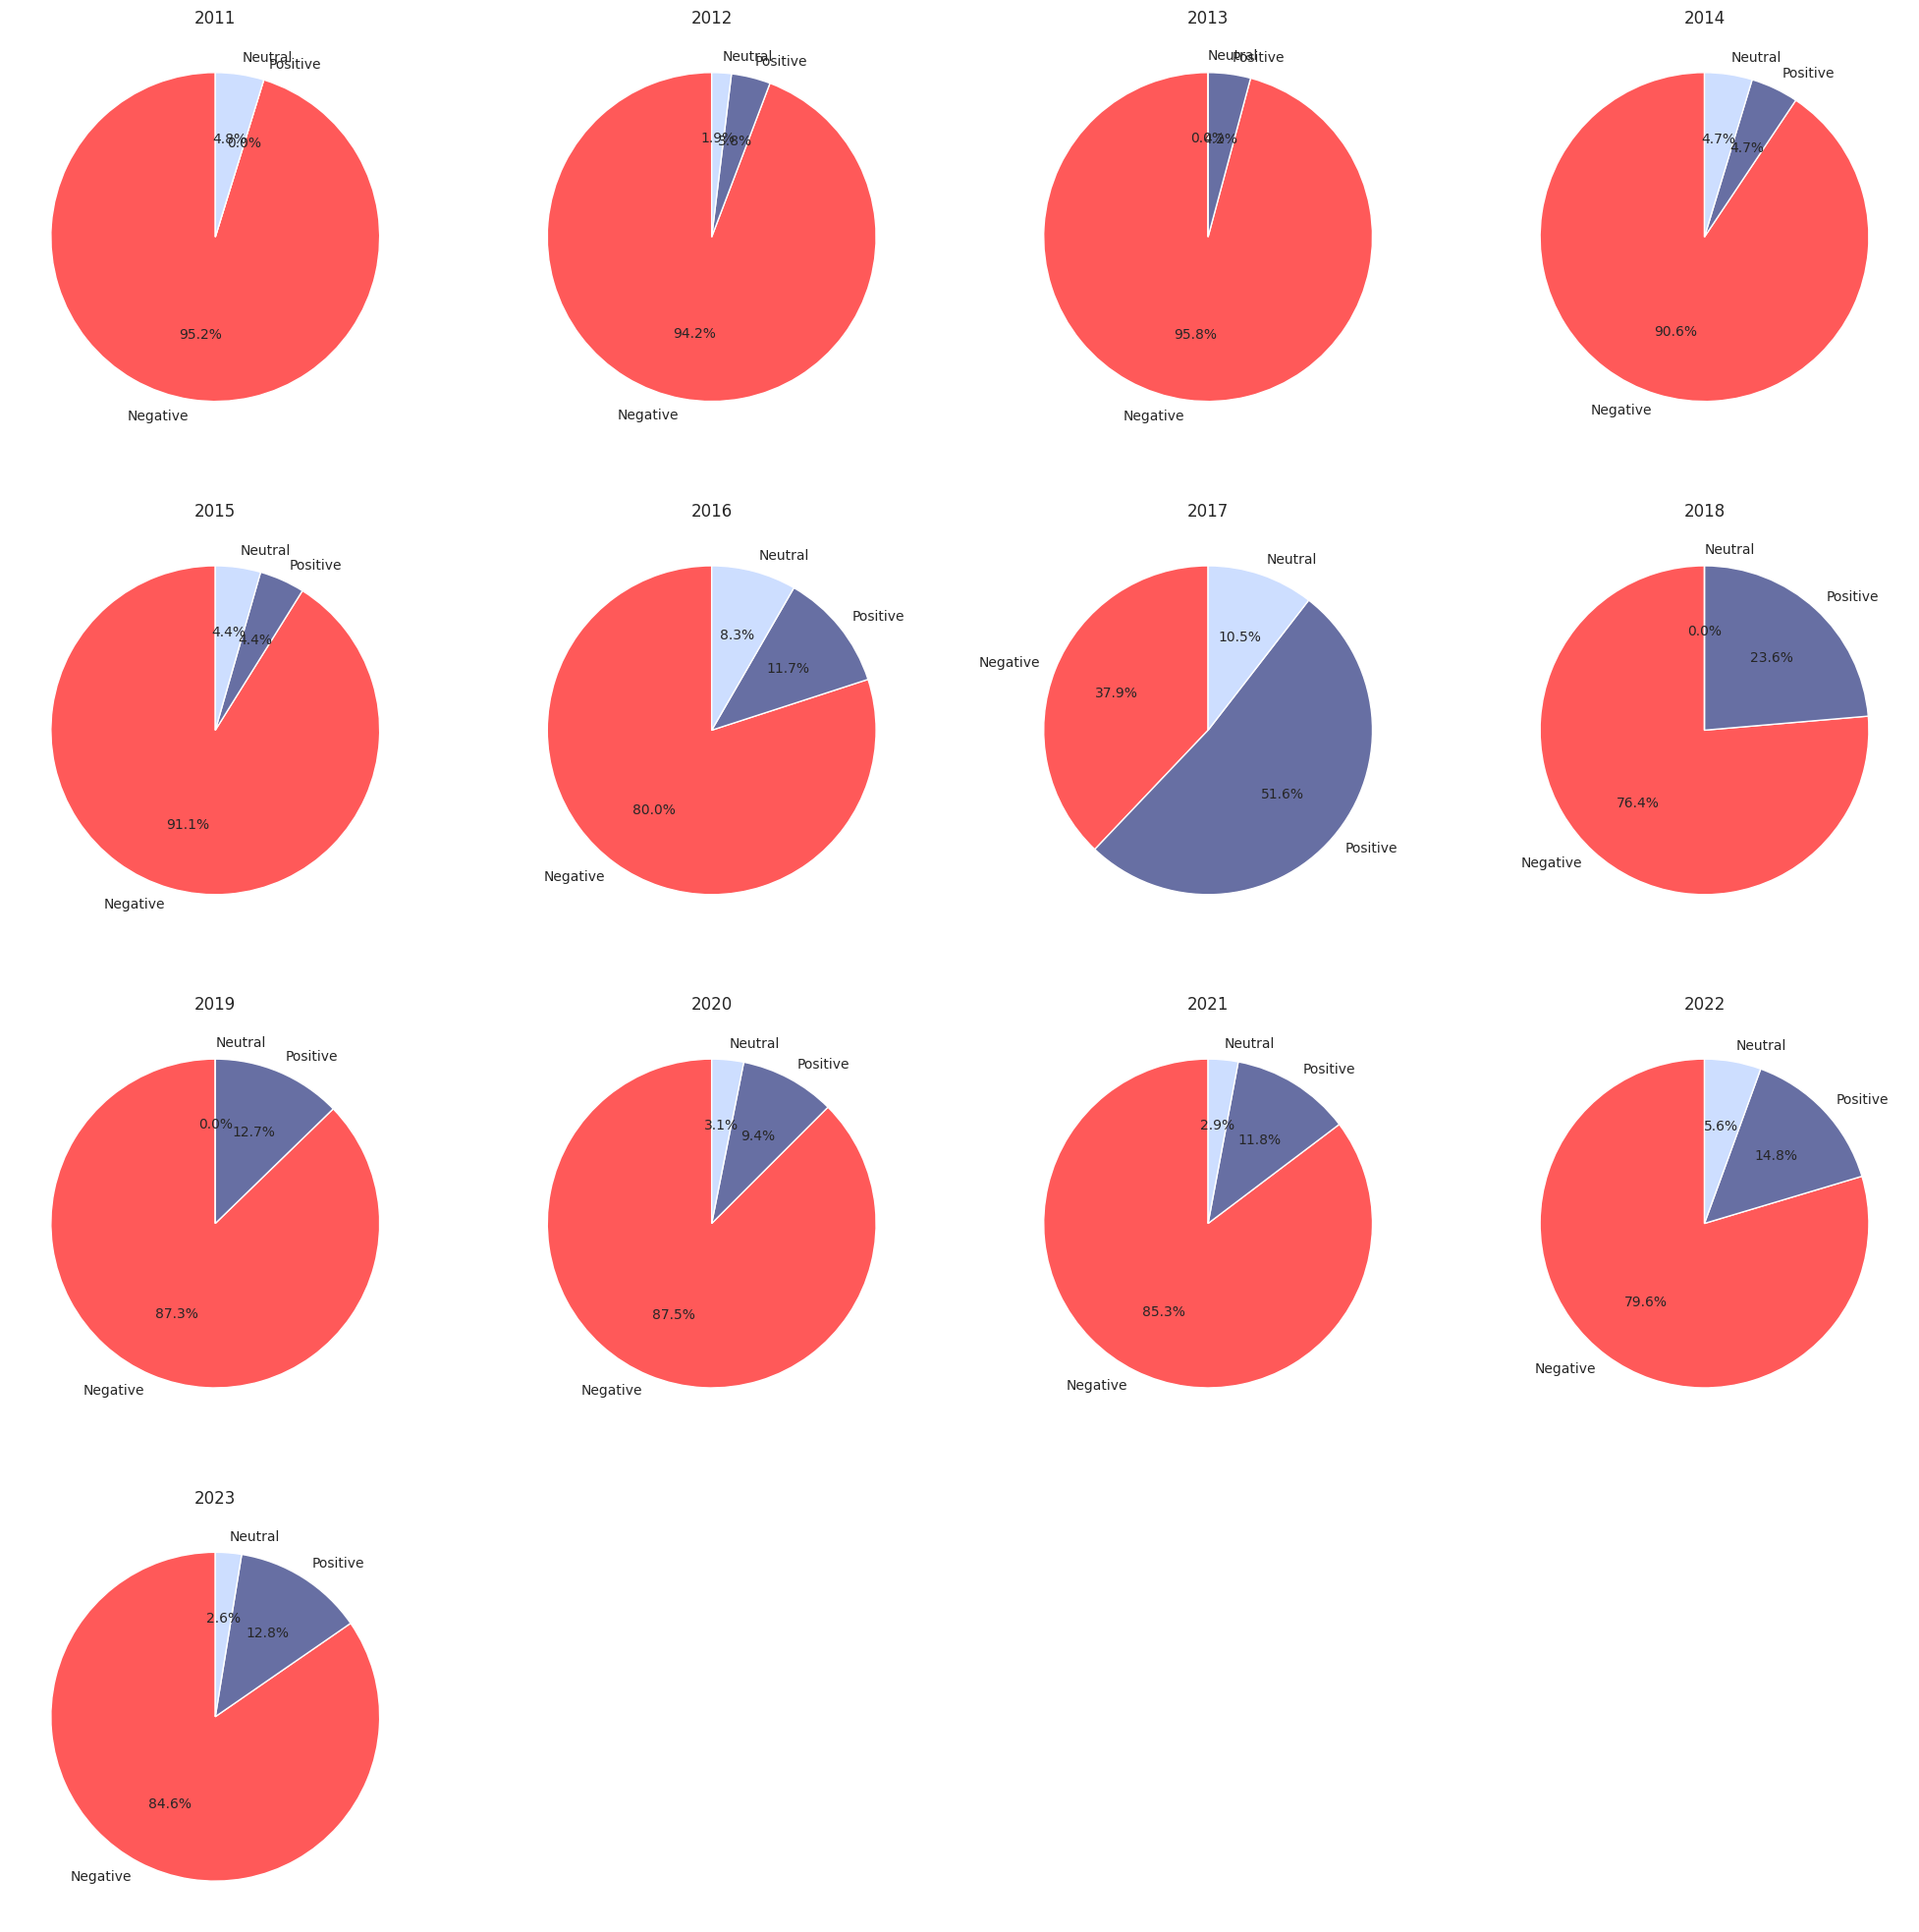

In [63]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4, 4, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

In [64]:
data = data[['Review','Rating']]

In [65]:
def cleaning(text):
  text = re.sub('[^a-zA-Z]',' ',str(text).lower().strip())
  text = re.sub('@[A-Za-z0-9_]+','',text)
  text = re.sub('#','',text)
  text = re.sub('RT[\s]+','',text)
  text = re.sub('https?:\/\/\S+','',text)
  text = re.sub('\n',' ',text)
  text = emoji.replace_emoji(text,replace='')
  return text

In [66]:
data['Review'] = data['Review'].apply(cleaning)

In [71]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

def lemm(data):
  wordnet = WordNetLemmatizer()
  lemmanized = []
  for i in range(len(data)):
    lemmed = []
    words = word_tokenize(data['Review'].iloc[i])
    for w in words:
      lemmed.append(wordnet.lemmatize(w))
    lemmanized.append(lemmed)

  data['lemmanized'] = lemmanized
  data['Review'] = data['lemmanized'].apply(' '.join)
  data = data.drop('lemmanized',axis=1)
  return data

data = lemm(data)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [72]:
data.head()

,Review,Rating
0,amber and ladonna at the starbucks on southwes...,1
1,at the starbucks by the fire station on in alt...,1
2,i just wanted to go out of my way to recognize...,1
3,me and my friend were at starbucks and my card...,1
4,i m on this kick of drinking cup of warm water...,1


In [73]:
labels = data['Rating']
training = data['Review']

In [74]:
X_train,X_test,y_train,y_test = train_test_split(training,labels,test_size=0.2,random_state=42)

In [75]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [76]:
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8014184397163121


In [77]:
model = DecisionTreeClassifier()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.7659574468085106


In [78]:
model = RandomForestClassifier()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8156028368794326


In [79]:
model = LinearSVC()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8439716312056738


In [80]:
model = MultinomialNB()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.7304964539007093


In [81]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)


X_train_padded = pad_sequences(X_train_seq,maxlen=100,padding='post')
X_val_padded = pad_sequences(X_val_seq,maxlen=100,padding='post')

In [84]:
model = Sequential([
    Embedding(20001,64,input_length=100,embeddings_regularizer=regularizers.l2(0.0005)),
    Dense(units=128, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=3, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
history = model.fit(X_train_padded,y_train,epochs=15,validation_data=(X_val_padded,y_test))

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.4830 - loss: 1.4558 - val_accuracy: 0.7305 - val_loss: 0.9842
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7868 - loss: 0.8311 - val_accuracy: 0.7305 - val_loss: 0.7761
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7887 - loss: 0.6366 - val_accuracy: 0.7305 - val_loss: 0.7227
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7844 - loss: 0.5796 - val_accuracy: 0.7305 - val_loss: 0.6831
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7924 - loss: 0.5231 - val_accuracy: 0.7305 - val_loss: 0.6513
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8332 - loss: 0.4661 - val_accuracy: 0.7518 - val_loss: 0.6139
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.4277 - val_accuracy: 0.7943 - val_loss: 0.5725
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9016 - loss: 0.3616 - val_accuracy: 0.8227 - val_los

In [87]:
evaluation_results = model.evaluate(X_val_padded,y_test)
print('Test Loss:',evaluation_results[0])
print('Test Accuracy:',evaluation_results[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8471 - loss: 0.5623 
Test Loss: 0.574203372001648
Test Accuracy: 0.8368794322013855


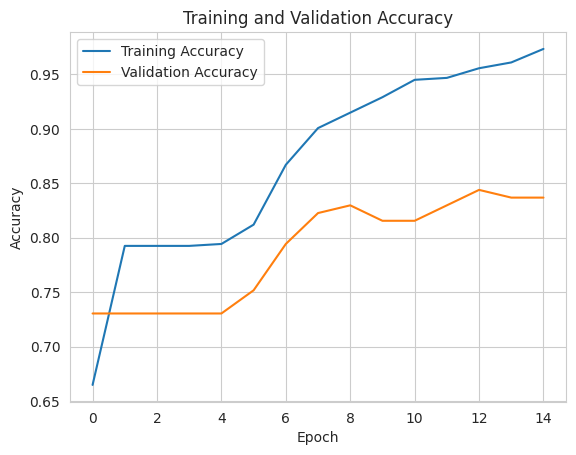

In [88]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [89]:
model = Sequential([
    Embedding(input_dim=20001,output_dim=32,input_length=100,embeddings_regularizer=regularizers.l2(0.0005)),
    LSTM(units=32,return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(units=32,activation='relu'),
    Dense(units=3,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [90]:
history = model.fit(X_train_padded,y_train,epochs=15,validation_data=(X_val_padded,y_test))

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6086 - loss: 1.2759 - val_accuracy: 0.7305 - val_loss: 1.0126
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7784 - loss: 0.8680 - val_accuracy: 0.7305 - val_loss: 0.8130
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7750 - loss: 0.6922 - val_accuracy: 0.7305 - val_loss: 0.7366
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7783 - loss: 0.6592 - val_accuracy: 0.7305 - val_loss: 0.7309
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7824 - loss: 0.6527 - val_accuracy: 0.7305 - val_loss: 0.7304
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7934 - loss: 0.6191 - val_accuracy: 0.7305 - val_loss: 0.7260
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8074 - loss: 0.5673 - val_accuracy: 0.7305 - val_loss: 0.7076
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7861 - loss: 0.5853 - val_accuracy: 0.7305 - v

In [92]:
evaluation_results = model.evaluate(X_val_padded,y_test)
print('Test Loss:',evaluation_results[0])
print('Test Accuracy:',evaluation_results[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8358 - loss: 0.6568 
Test Loss: 0.6404190063476562
Test Accuracy: 0.8368794322013855


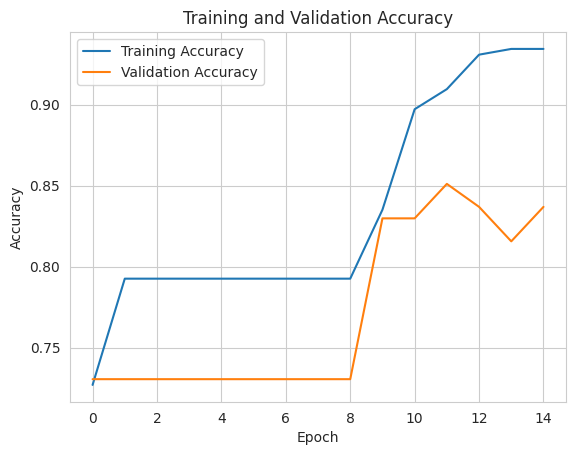

In [93]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()